# Optimization

Text(0, 0.5, 'Acceleration (m/s$^2$)')

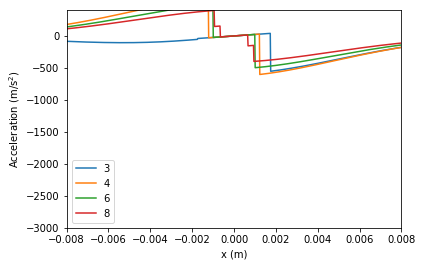

In [26]:
## optimistic implementation: set up the experiment
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
np.seterr(all='ignore')
from parametric import Parameter
from MOTorNOT.mot import GratingMOT
from MOTorNOT.coils import QuadrupoleCoils, LinearQuadrupole
from MOTorNOT.integration import Solver, generate_initial_conditions
from MOTorNOT.maxwell_boltzmann import MaxwellBoltzmann

linewidth = 2*np.pi*29e6

def capture_velocity(self, phi=90, theta=0):
    ''' Run a simulation to determine the capture velocity of the MOT. '''
    X0, V0 = generate_initial_conditions(-0.005, np.linspace(1, 75, 300), phi=phi, theta=theta)
    sol = Solver(self.acceleration, X0, V0).run(20e-2, dt=1e-5)           
    vi, vf = sol.capture_velocity()
    return vf

class MOTExperiment:
    coil_radius = Parameter('Coil radius (m)', 0.1)
    coil_offset = Parameter('Coil offset', 0.1)
    coil_turns = Parameter('coil turns', 100)
    coil_current = Parameter('coil current', 80)
    coil_delta = Parameter('coil delta', 0)
    field_gradient = Parameter('field gradient', 50e-2)
    detuning = Parameter('detuning', -2*linewidth)
    alpha = Parameter('diffraction angle', 30)
    radius = Parameter('radius', 10e-3)
    power = Parameter('power', 20e-3)
    sectors = Parameter('sectors', 3)
    cutoff = Parameter('cutoff', 10e-3)
    position = Parameter('position', 3e-3)

    def make_gmot(self):
#         field = LinearQuadrupole(self.field_gradient()).field
        field = QuadrupoleCoils(radius=self.coil_radius(), 
                                offset=self.coil_offset(), 
                                turns=self.coil_turns(), 
                                current=self.coil_current(), 
                                axis=2, deltaI=self.coil_delta()).field
        gmot = GratingMOT(position = self.position(), 
                          alpha = self.alpha(), 
                          detuning = self.detuning(), 
                          radius = self.radius(), 
                          power = self.power(), 
                          handedness = -1, 
                          R1 = 1/self.sectors(), 
                          field = field,
                          sectors=self.sectors(),
                          beam_type='gaussian',
                          grating_radius=self.cutoff())
        return gmot
    
    def capture_velocity(self):
            ''' Create a slower with the current instance parameters and determine 
                the capture fraction.
            '''
            return capture_velocity(self.make_gmot(), phi=90, theta=0)
        
    def force_curve(self):
        Z, _ = generate_initial_conditions(np.linspace(-self.radius(), self.radius(), 1000), 0, phi=90, theta=90)
        plt.plot(Z[:, 0], self.make_gmot().acceleration(Z, _)[:, 0], label=self.sectors())
        
exp = MOTExperiment()
for p in [3, 4, 6, 8]:
    exp.sectors(p)
    exp.force_curve()
    
plt.xlim([-8e-3, .008])
plt.ylim([-3000, 400])
# exp.make_gmot().plot(plane='xz')
plt.legend()
plt.xlabel(r'x (m)')
plt.ylabel(r'Acceleration (m/s$^2$)')

In [27]:
exp.sectors(3)
# exp.cutoff(10e-3)
# exp.radius(10e-3)
exp.coil_delta(-12)
exp.position(2e-3)
# exp.alpha(60)
# exp.detuning(-linewidth/2)
exp.make_gmot().plot('xz', limits=[(-10e-3, 10e-3), (-8e-3, 8e-3)], numpoints=80, quiver_scale=20)

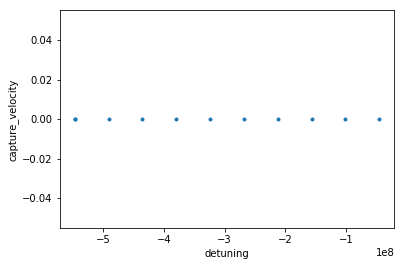

In [28]:
## run a 1D study
from optimistic.algorithms import GridSearch
grid = GridSearch.study(exp.capture_velocity, exp.detuning, (-3*linewidth, -0.25*linewidth), steps=10)
# grid = GridSearch.study(exp.capture_velocity, exp.sectors, (3, 8), steps=6)

In [11]:
X0, V0 = generate_initial_conditions(-0.005, np.linspace(1, 75, 300), phi=90, theta=90)
sol = Solver(exp.make_gmot().acceleration, X0, V0).run(20e-2, dt=1e-5)  

In [12]:
sol.capture_velocity()

(1.0, 4.217391304347826)